![Caption](images/Q08.png)

1. Neural networks is a type of machine learning algorithm which can perform may types of image analysis task. The network functions by approximating some function $f$ from an input $\textbf{x}$ and its output $\textbf{y}$. This is done through the learning of a set of parameters $\theta$, based on a dataset with inputs $\textbf{X}$ and corresponding outputs $\textbf{Y}$.
2. The network we study in this particular case is a feed forward neural network which is implemented as a connected graph. Network consists of a series of nodes in layers, called neurons. The network will have one input layer, a series of hidden layers and an output layer. These layers are connected by edges sequentially, and the weightings of those edges are part the parameters that we learn during training of our neural network. The number of inputs depends on the dimensionality of one sample from $\textbf{X}$ and the output depends on the number of classes in $\textbf{Y}$ or can be a continous output depending on the setting the analysis problem.

![Caption](images/networkarchitecture.png)

3. Predictions, or feedforward occurs sequentially. The output of one particular node $i$ in layer $l$, $h_{j}^l$ is: $h_j^l = a_l(\sum_{q} h_q^{l-1}w_{qj}^l)$ where $a_l$ is an activation function, in our case the non-linear activation ReLU. In classification problems we perform softmax at the output layer in order to gain probabilities of classes which is required for the backpropogation training algorithm.
4. We train the weightings of our connections using gradient descent through an algorithm called backpropogation. In order to do so we compute the loss of our network, which is another word for the error rate of our classifications. We use the cross entropy loss function $L = -\sum_{k}t_k\text{log}(y_n)$.
5. In order to perform gradient descent we calculate $\frac{\partial{L}}{\partial w_{ij}^{l}} = \frac{\partial{L}}{\partial z_{i}^{l}}\frac{\partial z_i^l}{ \partial w_{ij}^{l}}$ where $z_i^l$ is $h_i^l$ prior to activation. We denote $\frac{\partial{L}}{\partial z_{i}^{l}} = \delta^l_i$ and $\frac{\partial z_i^l}{ \partial w_{ij}^{l}} = h_i^{l-1}$.
6. We start from the last layer where we due to our softmax activation function simply have $\delta_i^L = y_i-t_i$ for node $i$ in layer $L$. To compute the gradients of the internal layers we have $\delta_i^l = a^{´l}(z_i^l)\sum_k w_{ki}^{l+1}\delta_k^{l+1}$.
7. After computing all of the gradients we update $w_{ij}^{l\text{new}} = w_{ij}^{l} - \eta\frac{\partial{L}}{\partial w_{ij}^{l}}$, where $\eta$ is a hyperparameter called learning rate we must tune.

8. When running experiments we note the following problems:
    * Simpler architectures makes the problem converge much faster if it sufficient for a problem. For example, increasing the number of layers or units in the first example where we have two clusters makes the model converge very slowly (and poorly). At the same time, example 2 requires a more complex network to capture the circular structure of the data.
    * Not standardizing the data makes the networks perform horribly (unless we somehow scale the initialisation of our weights). We learned this the hard way....
    * Initializing of weights matters A LOT for converge. With too large weights intially we get exploding gradients 

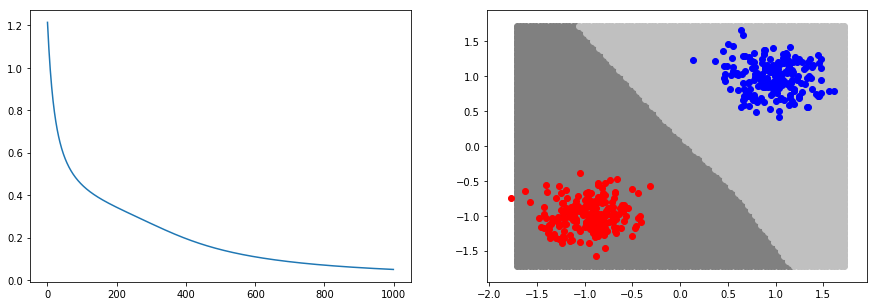

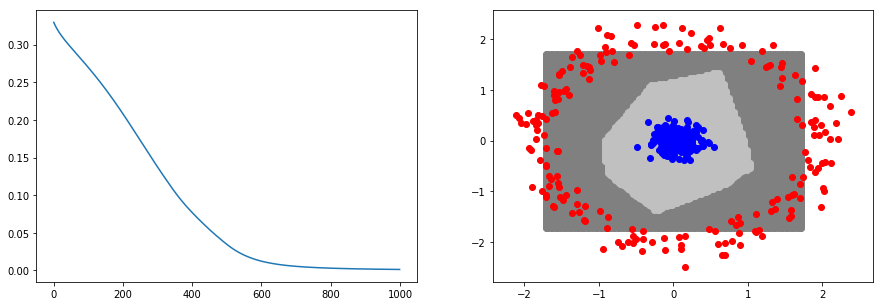

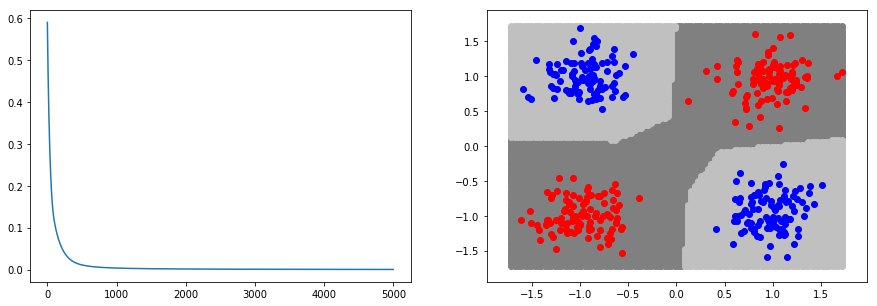

In [385]:
from scipy.special import softmax
def init_weights_bias(neurons_in_layers):
    W = []
    b = []
    for i in range(len(neurons_in_layers)-1):
        std = math.sqrt(2)*math.sqrt(2.0/(float(neurons_in_layers[i])+float(neurons_in_layers[i+1])))
        W.append(np.random.normal(loc=0.0, scale=std, size=[neurons_in_layers[i],neurons_in_layers[i+1]])) 
        b.append(np.random.normal(loc=0.0, scale=std, size=[1, neurons_in_layers[i+1]])) 
    return (W, b)
def forward_pass(NN, x):
    #x: The input of the network             (np.array of shape: (batch_size, number_of_features))
    #NN: The initialized neural network      (tuple of list of matrices)
    z = [x]
    a = []
    for l in range(len(NN[0])):
        a.append(np.einsum('bi, io -> bo', z[l], NN[0][l]) + NN[1][l])  # The affine transform x*w+b
        if l+1 != len(NN[0]):
            z.append(np.maximum(a[l], 0))
        else:
            z.append(softmax(a[l], axis=1))
    return z, a

def backward_pass(x, t, z, a, NN):
    y = z[-1] #Apply softmax to z to get probability of each class
    delta = y-t # Delta for the last layer
    d_a = []
    for i in range(len(a)):
        d_a.append(z[i])
    g_w = [] 
    g_b = []
    g_b.append(np.mean(delta, axis=0))
    g_w.append(np.mean(np.einsum('bo, bi -> bio', delta, z[-2]), axis=0))
    
    for l in range(1, len(NN[0])):
        d_C_d_z = np.einsum('bo, io -> bi', delta, NN[0][-l])  # Derivative of the Cost with respect to an activated layer d_C_d_z. 
                                                               #  delta shape: as above; weights shape: (i, o)
                                                               # Delta: d_C_d_z (element-wise mult) derivative of the activation layers
                                                               #  delta shape: as above; d_z shape: (b, i)  
        delta = np.einsum('bi, bi -> bi', d_C_d_z, d_a[-l])     # <- Insert correct expression                                      
        g_b.append(np.mean(delta, axis=0)) 
        g_w.append(np.mean(np.einsum('bo, bi -> bio', delta, z[-l-2]), axis=0)) # Derivative of cost with respect to weights in layer l:
                                                                           # delta shape: as above; activations of l-1 shape: (b, i)
    return g_b[::-1], g_w[::-1]

def normalize_data(data):
    train_mu = np.mean(data, axis=0)
    train_sigma = np.std(data, axis=0)
    data = (data-train_mu)/train_sigma
    return data
    
def cross_entropy_loss(target, y, derivative=False):
    """
    Computes the cross entropy loss function and its derivative 
    Input:
    target:      target (expected output)          (np.array)
    y:      output from forward pass (np.array, must be the same shape as t)
    derivative: whether to return the derivative with respect to y or return the loss (boolean)
    """
    if derivative:
        return (y-t)
    else:
        return -target*np.log(y) 
X, T, test, dim = make_data(example_nr=1, n=200, noise=0.5)
X = normalize_data(X)
test = normalize_data(test)
layers = [2, 4, 2]
eta = 0.01
NN = init_weights_bias(layers)
train_loss = []
for i in range(1000):
    z, a = forward_pass(NN, X)
    g_b, g_w = backward_pass(X, T, z, a, NN)
    train_loss.append(np.mean(cross_entropy_loss(T, z[-1])))
    for l in range(len(g_b)):
            NN[0][l] -= g_w[l]*eta
            NN[1][l] -= g_b[l]*eta
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(train_loss)
z, a = forward_pass(NN, test)
class_0_x = []
class_0_y = []
class_1_x = []
class_1_y = []
for a_pred in zip(z[-1], test):
    prediction = np.argmax(a_pred[0])
    if prediction == 0:
        class_0_x.append(a_pred[1][0])
        class_0_y.append(a_pred[1][1])
    elif prediction == 1:
        class_1_x.append(a_pred[1][0])
        class_1_y.append(a_pred[1][1])
ax2.scatter(class_0_x,class_0_y, color='gray')
ax2.scatter(class_1_x,class_1_y, color='silver')
z, a = forward_pass(NN, X)

class_0_x = []
class_0_y = []
class_1_x = []
class_1_y = []
for a_class in zip(z[-1], X):
    prediction = np.argmax(a_class[0])
    if prediction == 0:
        class_0_x.append(a_class[1][0])
        class_0_y.append(a_class[1][1])
    elif prediction == 1:
        class_1_x.append(a_class[1][0])
        class_1_y.append(a_class[1][1]) 
ax2.scatter(class_0_x,class_0_y, color='red')
ax2.scatter(class_1_x,class_1_y, color='blue')
fig.set_size_inches((15,5))
plt.show()

X, T, test, dim = make_data(example_nr=2, n=200, noise=0.5)
X = normalize_data(X)
test = normalize_data(test)

layers = [2, 10,5, 2]
eta = 0.01
NN = init_weights_bias(layers)
train_loss = []
for i in range(1000):
    z, a = forward_pass(NN, X)
    g_b, g_w = backward_pass(X, T, z, a, NN)
    train_loss.append(np.mean(cross_entropy_loss(T, z[-1])))
    for l in range(len(g_b)):
            NN[0][l] -= g_w[l]*eta
            NN[1][l] -= g_b[l]*eta
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(train_loss)
z, a = forward_pass(NN, test)
class_0_x = []
class_0_y = []
class_1_x = []
class_1_y = []
for a_pred in zip(z[-1], test):
    prediction = np.argmax(a_pred[0])
    if prediction == 0:
        class_0_x.append(a_pred[1][0])
        class_0_y.append(a_pred[1][1])
    elif prediction == 1:
        class_1_x.append(a_pred[1][0])
        class_1_y.append(a_pred[1][1])
ax2.scatter(class_0_x,class_0_y, color='gray')
ax2.scatter(class_1_x,class_1_y, color='silver')
z, a = forward_pass(NN, X)

class_0_x = []
class_0_y = []
class_1_x = []
class_1_y = []
for a_class in zip(z[-1], X):
    prediction = np.argmax(a_class[0])
    if prediction == 0:
        class_0_x.append(a_class[1][0])
        class_0_y.append(a_class[1][1])
    elif prediction == 1:
        class_1_x.append(a_class[1][0])
        class_1_y.append(a_class[1][1]) 
ax2.scatter(class_0_x,class_0_y, color='red')
ax2.scatter(class_1_x,class_1_y, color='blue')
fig.set_size_inches((15,5))
plt.show()
X, T, test, dim = make_data(example_nr=3, n=200, noise=0.5)
X = normalize_data(X)
test = normalize_data(test)
layers = [2, 8, 2]
eta = 0.05
NN = init_weights_bias(layers)
train_loss = []
for i in range(5000):
    z, a = forward_pass(NN, X)
    g_b, g_w = backward_pass(X, T, z, a, NN)
    train_loss.append(np.mean(cross_entropy_loss(T, z[-1])))
    for l in range(len(g_b)):
            NN[0][l] -= g_w[l]*eta
            NN[1][l] -= g_b[l]*eta
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(train_loss)
z, a = forward_pass(NN, test)
class_0_x = []
class_0_y = []
class_1_x = []
class_1_y = []
for a_pred in zip(z[-1], test):
    prediction = np.argmax(a_pred[0])
    if prediction == 0:
        class_0_x.append(a_pred[1][0])
        class_0_y.append(a_pred[1][1])
    elif prediction == 1:
        class_1_x.append(a_pred[1][0])
        class_1_y.append(a_pred[1][1])
ax2.scatter(class_0_x,class_0_y, color='gray')
ax2.scatter(class_1_x,class_1_y, color='silver')
z, a = forward_pass(NN, X)

class_0_x = []
class_0_y = []
class_1_x = []
class_1_y = []
for a_class in zip(z[-1], X):
    prediction = np.argmax(a_class[0])
    if prediction == 0:
        class_0_x.append(a_class[1][0])
        class_0_y.append(a_class[1][1])
    elif prediction == 1:
        class_1_x.append(a_class[1][0])
        class_1_y.append(a_class[1][1]) 
ax2.scatter(class_0_x,class_0_y, color='red')
ax2.scatter(class_1_x,class_1_y, color='blue')
fig.set_size_inches((15,5))
plt.show()

